# JoyMNIST

- Author: Youngsup Kim, idebtor@gmail.com
- 2018.09.01 - creation
- 2018.10.20 - updated for KOICA Students


# MINIST - Mixed National Institute of Standards and Technology

MNIST dataset is widely used for “classification”, “image recognition” task. This is considered as relatively simple task, and often used for “Hello world” program in machine learning category. It is also often used to compare algorithm performances in research.

Many machine learning libraries like sklearn in python already provide easy access to the MNIST dataset. What you then compare is the Error of your algorithm compared to the other algorithms: [MNIST handwritten digit database, Yann LeCun, Corinna Cortes and Chris Burges](http://yann.lecun.com/exdb/mnist/)

MNIST (Mixed [National Institute of Standards and Technology](https://en.wikipedia.org/wiki/National_Institute_of_Standards_and_Technology)) database is dataset for handwritten digits, distributed by Yann Lecun’s THE [MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/) website.

- [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)

The dataset consists of pair, “handwritten digit image” and “label”. Digit ranges from 0 to 9, meaning 10 patterns in total.

- handwritten digit image: This is gray scale image with size 28 x 28 pixel.
- label : This is actual digit number this handwritten digit image represents. It is either  0 to 9.


<img src="images/mnist_sample10x10.png" width="600">
<center>Figure 1: First 100 samples of MNIST Dataset</center>

## Handling MNIST dataset with Chainer

For these famous datasets like MNIST, Chainer provides utility function to prepare dataset. So you don’t need to write preprocessing code by your own, downloading dataset from internet, and extract it, followed by formatting it etc… Chainer function do it for you!

Currently,
- MNIST
- CIFAR-10, CIFAR-100

are supported, refer [Official document for dataset](http://docs.chainer.org/en/stable/reference/datasets.html#concrete-datasets).

Let’s get familiar with MNIST dataset handling at first. Below codes are based on mnist_dataset_introduction.ipynb. To prepare MNIST dataset, you just need to call chainer.datasets.get_mnist function.

In [1]:
import numpy as np
import chainer

# Load the MNIST dataset from pre-inn chainer method
train, test = chainer.datasets.get_mnist()

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


__JoyTips__

In anaconda environment, you may not have chainer installed. Then take the following steps.

- Open a console window and 
    - pip install chainer
    - conda install chainer
- Select Kernel and Restart

If this is first time, it starts downloading the dataset which might take several minutes. From second time, chainer will refer the cached contents automatically so it runs faster.

You will get 2 returns, each of them corresponds to “training dataset” and “test dataset”.

MNIST have total 70000 data, where training dataset size is 60000, and test dataset size is 10000.

In [2]:
# train[i] represents i-th data, there are 60000 training data
# test data structure is same, but total 10000 test data
print('len(train), type ', len(train), type(train))
print('len(test), type ', len(test), type(test))

len(train), type  60000 <class 'chainer.datasets.tuple_dataset.TupleDataset'>
len(test), type  10000 <class 'chainer.datasets.tuple_dataset.TupleDataset'>


I will explain about only train dataset below, but test dataset have same dataset format.

`train[i]` represents i-th data, `type=tuple`($ x_i $, $y_i $), where $ x_i $ is image data in array format with size 784, and $y_i$ is label data indicates actual digit of image.

In [3]:
# train[i][0] represents x_i, MNIST image data,
# type=numpy(784,) vector <- specified by ndim of get_mnist()
print('train[0][0] shape =', train[0][0].shape)
np.set_printoptions(threshold=10)  # set np.inf to print all.
print('train[0][0] =', train[0][0])


train[0][0] shape = (784,)
train[0][0] = [0. 0. 0. ... 0. 0. 0.]


$y_i $ information. In below case you can see that 0-th image has label "5".

In [4]:
# train[i][1] represents y_i, MNIST label data(0-9), type=numpy() -> 
# this means scalar
print('train[0][1] shape =', train[0][1].shape)
print('train[0][1] =', train[0][1])

train[0][1] shape = ()
train[0][1] = 5


### Plotting MNIST

So, each i-th dataset consists of image and label

- `train[i][0] or test[i][0]`: i-th handwritten image
- `train[i][1] or test[i][1]`: i-th label

Below is a plotting code to check how images (this is just an array vector in python program) look like. 

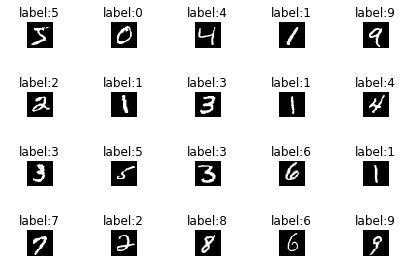

In [6]:
import os

import chainer
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = 'images'

# Load the MNIST dataset from pre-inn chainer method
train, test = chainer.datasets.get_mnist(ndim=1)

ROW = 4
COLUMN = 5
for i in range(ROW * COLUMN):
    # train[i][0] is i-th image data with size 28x28
    image = train[i][0].reshape(28, 28)    # not necessary to reshape if ndim is set to 2
    plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
    plt.imshow(image, cmap='gray')         # cmap='gray' is for black and white picture.
    plt.title('label:{}'.format(train[i][1])) # train[i][1] is i-th digit label
    plt.axis('off')  # do not show axis value
plt.tight_layout()   # automatic padding between subplots
#plt.savefig(os.path.join(base_dir, 'mnist_plot.png'))
#plt.show()


## MNIST training with Multi Layer Perceptron

<img src="images/784-100-10NN.png" width="600">
<center>Figure 2:  MNIST training with Three Layer Neural Network</center>


### Training MNIST

You already studied basics of `Chainer` and MNIST dataset. Now we can proceed to the MNIST classification task. We want to create a classifier that classifies MNIST handwritten image into its digit. In other words, classifier will get array which represents MNIST image as input and outputs its label.

※ Chainer contains modules called `Trainer, Iterator, Updater`, which makes your training code more organized. It is quite nice to write your training code by using them in higher level syntax. However, its abstraction makes difficult to understand what is going on during the training. For those who want to learn deep learning in more detail, I think it is nice to know “primitive way” of writing training code. Therefore, I intentionally don’t to use these modules at first to explain training code.

Before going to read the explanation, execute the following cell. 

In [7]:
"""
Very simple implementation for MNIST training code with Chainer using
Multi Layer Perceptron (MLP) model
This code is to explain the basic of training procedure.
"""
from __future__ import print_function
import time
import os
import numpy as np
import six

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import serializers


class MLP(chainer.Chain):
    """Neural Network definition, Multi Layer Perceptron"""
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred when `None`
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)    # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y


class SoftmaxClassifier(chainer.Chain):
    """Classifier is for calculating loss, from predictor's output.
    predictor is a model that predicts the probability of each label.
    """
    def __init__(self, predictor):
        super(SoftmaxClassifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss


def main():
    # Configuration setting
    gpu = -1                  # GPU ID to be used for calculation. -1 indicates to use only CPU.
    batchsize = 100           # Minibatch size for training
    epoch = 20                # Number of training epoch
    out = 'result/1'  # Directory to save the results
    unit = 50                 # Number of hidden layer units, try incresing this value and see if how accuracy changes.

    print('GPU: {}'.format(gpu))
    print('# unit: {}'.format(unit))
    print('# Minibatch-size: {}'.format(batchsize))
    print('# epoch: {}'.format(epoch))
    print('out directory: {}'.format(out))

    # Set up a neural network to train
    model = MLP(unit, 10)
    # Classifier will calculate classification loss, based on the output of model
    classifier_model = SoftmaxClassifier(model)

    if gpu >= 0:
        chainer.cuda.get_device(gpu).use()  # Make a specified GPU current
        classifier_model.to_gpu()           # Copy the model to the GPU
    xp = np if gpu < 0 else cuda.cupy

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(classifier_model)

    # Load the MNIST dataset
    train, test = chainer.datasets.get_mnist()

    n_epoch = epoch
    N = len(train)       # training data size
    N_test = len(test)  # test data size

    # Learning loop
    for epoch in range(1, n_epoch + 1):
        print('epoch', epoch)

        # training
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        start = time.time()
        for i in six.moves.range(0, N, batchsize):
            x = chainer.Variable(xp.asarray(train[perm[i:i + batchsize]][0]))
            t = chainer.Variable(xp.asarray(train[perm[i:i + batchsize]][1]))

            # Pass the loss function (Classifier defines it) and its arguments
            optimizer.update(classifier_model, x, t)

            sum_loss += float(classifier_model.loss.data) * len(t.data)
            sum_accuracy += float(classifier_model.accuracy.data) * len(t.data)
        end = time.time()
        elapsed_time = end - start
        throughput = N / elapsed_time
        print('train mean loss={}, accuracy={}, throughput={} images/sec'.format(
            sum_loss / N, sum_accuracy / N, throughput))

        # evaluation
        sum_accuracy = 0
        sum_loss = 0
        for i in six.moves.range(0, N_test, batchsize):
            index = np.asarray(list(range(i, i + batchsize)))
            x = chainer.Variable(xp.asarray(test[index][0]))
            t = chainer.Variable(xp.asarray(test[index][1]))

            loss = classifier_model(x, t)
            sum_loss += float(loss.data) * len(t.data)
            sum_accuracy += float(classifier_model.accuracy.data) * len(t.data)

        print('test  mean loss={}, accuracy={}'.format(
            sum_loss / N_test, sum_accuracy / N_test))

    # Save the model and the optimizer
    if not os.path.exists(out):
        os.makedirs(out)
    print('save the model')
    serializers.save_npz('{}/classifier_mlp.model'.format(out), classifier_model)
    serializers.save_npz('{}/mlp.model'.format(out), model)
    print('save the optimizer')
    serializers.save_npz('{}/mlp.state'.format(out), optimizer)

if __name__ == '__main__':
    main()

GPU: -1
# unit: 50
# Minibatch-size: 100
# epoch: 20
out directory: result/1
epoch 1
train mean loss=0.41171753817548357, accuracy=0.8825666669507821, throughput=24445.016250328197 images/sec
test  mean loss=0.20489588641561568, accuracy=0.9379000025987625
epoch 2
train mean loss=0.17729322012513876, accuracy=0.9488166674971581, throughput=24415.184049436873 images/sec
test  mean loss=0.15178478020709008, accuracy=0.9548000007867813
epoch 3
train mean loss=0.13507697496873636, accuracy=0.960050003429254, throughput=24798.396084573313 images/sec
test  mean loss=0.12086793611641042, accuracy=0.9634000039100648
epoch 4
train mean loss=0.10834557069310298, accuracy=0.9679166727264722, throughput=24484.882284257208 images/sec
test  mean loss=0.11562775911064818, accuracy=0.9655000072717667
epoch 5
train mean loss=0.09058468349277973, accuracy=0.9731666750709216, throughput=23730.011196539916 images/sec
test  mean loss=0.09896783903008327, accuracy=0.9698000025749206
epoch 6
train mean loss=

You can see the log like below, indicating that the loss in decreasing through the training and accuracy is increasing. Of course, it is ok that you may not understand the meaning of this log here. I will explain the detail one by one in the following.

## Define Network and loss function

Let’s adopt Multi Layer Perceptron (MLP), which is a most simple neural network, as our model. This is written as follows with Chainer,

In [8]:
class MLP(chainer.Chain):
    """Neural Network definition, Multi Layer Perceptron"""
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred when `None`
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)    # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

This model is graphically drawn as follows. All nodes are fully connected, and the network with this kinds of structure is called MLP (Multi layer perceptron).

The fast part is input layer and the last part is output layer. The rest middle part of the layer is called “hidden layer”. This example contains only 1 hidden layer, but hidden layers may exist more than 1 in general (If you construct the network deeper, the number of hidden layer increases). 

<img src="images/mlp.png" width="600">
<center>Figure 3: MLP(Multi Layer Perceptron</center>

As written in __call__ function, it will take x (array indicating image) as input and return y (indicating predicted probability for each label) as output.

However, this is not enough for training the model. We need loss function to be optimized. In classification task, softmax cross entropy loss is often used.

Output of Linear layer can take arbitrary real number, Softmax function converts it into between 0-1, thus we can consider it as “probability for this label”. Cross entropy is to calculate loss between two probability distributions. Chainer has utility function F.softmax_cross_entropy(y, t) to calculate softmax of y followed by cross entropy with t. Loss will be smaller if the probability distribution predicted as y is equal to the actual probability distribution t. Intuitively, loss decreases when model can predict correct label given image.

Here I will skip more detail explanation, please study by yourself. Here is some reference,

- [UFLDL Tutorial: Softmax Regression](http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/)
- [Wikipedia: Softmax function](https://en.wikipedia.org/wiki/Softmax_function)

To calculate softmax cross entropy loss, we define another Chain class, named SoftmaxClassifier as follows,

In [9]:
class SoftmaxClassifier(chainer.Chain):
    """Classifier is for calculating loss, from predictor's output.
    predictor is a model that predicts the probability of each label.
    """
    def __init__(self, predictor):
        super(SoftmaxClassifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

Then, the model is instantiated as


In [10]:
unit = 50   # Number of hidden layer units, try incresing this value and see if how accuracy changes.

# Set up a neural network to train
model = MLP(unit, 10)
# Classifier will calculate classification loss, based on the output of model
classifier_model = SoftmaxClassifier(model)

First, `MLP model` is created. `n_out` is set to 10 because MNIST has 10 patterns, from 0 until 9, in label. Then `classifier_model` is created based on the `MLP model` as its `predictor`. As you can see here, Network of Chain class can be “chained” to construct new network which is also Chain class. I guess this is the reason the name “Chainer” comes from.

Once loss function calculation is defined in `__call__` function of model, you can set this model into `Optimizer` to proceed training.

In [24]:
# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(classifier_model)

Load the MNIST dataset and training proceeds ....

The following code will calculate the loss as classifier_model(x, t) and tune (optimize) internal paramaters of model with Optimizer’s algorithm (Adam in this case).

Note that Back propagation is done automatically inside this update code, so you don’t need to write these codes explicitly.

__ Pass the loss function (Classifier defines it) and its arguments __

            `optimizer.update(classifier_model, x, t)`

## Train and Evaluation (Test)

The code consists of two phases, training phase and evaluation (test) phase.

In regression/classification task in machine learning, you need to verify the model’s generalization performance. Even loss is decreasing with training dataset, it is not always true that loss for test (unseen) dataset is small.

Especially, we should take care [overfitting](https://en.wikipedia.org/wiki/Overfitting) problem. To cooperate this, you can check test dataset loss also decreases through the training.

### Training Phase

- optimizer.update code will update model’s internal parameter to decrease loss.
- Random permutation is to get random sample for constructing minibatch.

If training loss is not decreasing from the beginning, the root cause may be bug or some hyper parameter setting is wrong. When training loss stops decreasing (saturated), it is ok to stop the training.

        # training
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        start = time.time()
        for i in six.moves.range(0, N, batchsize):
            x = chainer.Variable(xp.asarray(train[perm[i:i + batchsize]][0]))
            t = chainer.Variable(xp.asarray(train[perm[i:i + batchsize]][1]))

            # Pass the loss function (Classifier defines it) and its arguments
            optimizer.update(classifier_model, x, t)

            sum_loss += float(classifier_model.loss.data) * len(t.data)
            sum_accuracy += float(classifier_model.accuracy.data) * len(t.data)
        end = time.time()
        elapsed_time = end - start
        throughput = N / elapsed_time
        print('train mean loss={}, accuracy={}, throughput={} images/sec'.format(
            sum_loss / N, sum_accuracy / N, throughput))

### Evaluation (test) phase

- We __must not__ call `optimizer.update` code. Test dataset is considered as unseen data for model. Should not be included as training information.
- We don’t need to take random permutation in test phase, only `sum_loss` and `sum_accuracy` is necessary.

Evaluation code does (should have) no affect to model. This is just to check loss for test dataset. Ideal pattern is of course test loss decreases through the training.

        # evaluation
        sum_accuracy = 0
        sum_loss = 0
        for i in six.moves.range(0, N_test, batchsize):
            index = np.asarray(list(range(i, i + batchsize)))
            x = chainer.Variable(xp.asarray(test[index][0]))
            t = chainer.Variable(xp.asarray(test[index][1]))

            loss = classifier_model(x, t)
            sum_loss += float(loss.data) * len(t.data)
            sum_accuracy += float(classifier_model.accuracy.data) * len(t.data)

        print('test  mean loss={}, accuracy={}'.format(
            sum_loss / N_test, sum_accuracy / N_test))

If this test loss is not decreasing while training loss is decreasing, it is a sign that model is overfitting. Then, you need to take action

- Increase the data size (if possible).
    - Data augmentation is one method to increase the data effectively.
- Decrease the number of internal parameters in neural network
    – Try more simple network
- Add Regularization term

Put all codes together,

In [ ]:
"""
Very simple implementation for MNIST training code with Chainer using
Multi Layer Perceptron (MLP) model

This code is to explain the basic of training procedure.

"""
from __future__ import print_function
import time
import os
import numpy as np
import six

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import serializers


class MLP(chainer.Chain):
    """Neural Network definition, Multi Layer Perceptron"""
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred when `None`
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)    # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y


class SoftmaxClassifier(chainer.Chain):
    """Classifier is for calculating loss, from predictor's output.
    predictor is a model that predicts the probability of each label.
    """
    def __init__(self, predictor):
        super(SoftmaxClassifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss


def main():
    # Configuration setting
    gpu = -1                  # GPU ID to be used for calculation. -1 indicates to use only CPU.
    batchsize = 100           # Minibatch size for training
    epoch = 20                # Number of training epoch
    out = 'result/1'  # Directory to save the results
    unit = 50                 # Number of hidden layer units, try incresing this value and see if how accuracy changes.

    print('GPU: {}'.format(gpu))
    print('# unit: {}'.format(unit))
    print('# Minibatch-size: {}'.format(batchsize))
    print('# epoch: {}'.format(epoch))
    print('out directory: {}'.format(out))

    # Set up a neural network to train
    model = MLP(unit, 10)
    # Classifier will calculate classification loss, based on the output of model
    classifier_model = SoftmaxClassifier(model)

    if gpu >= 0:
        chainer.cuda.get_device(gpu).use()  # Make a specified GPU current
        classifier_model.to_gpu()           # Copy the model to the GPU
    xp = np if gpu < 0 else cuda.cupy

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(classifier_model)

    # Load the MNIST dataset
    train, test = chainer.datasets.get_mnist()

    n_epoch = epoch
    N = len(train)       # training data size
    N_test = len(test)  # test data size

    # Learning loop
    for epoch in range(1, n_epoch + 1):
        print('epoch', epoch)

        # training
        perm = np.random.permutation(N)
        sum_accuracy = 0
        sum_loss = 0
        start = time.time()
        for i in six.moves.range(0, N, batchsize):
            x = chainer.Variable(xp.asarray(train[perm[i:i + batchsize]][0]))
            t = chainer.Variable(xp.asarray(train[perm[i:i + batchsize]][1]))

            # Pass the loss function (Classifier defines it) and its arguments
            optimizer.update(classifier_model, x, t)

            sum_loss += float(classifier_model.loss.data) * len(t.data)
            sum_accuracy += float(classifier_model.accuracy.data) * len(t.data)
        end = time.time()
        elapsed_time = end - start
        throughput = N / elapsed_time
        print('train mean loss={}, accuracy={}, throughput={} images/sec'.format(
            sum_loss / N, sum_accuracy / N, throughput))

        # evaluation
        sum_accuracy = 0
        sum_loss = 0
        for i in six.moves.range(0, N_test, batchsize):
            index = np.asarray(list(range(i, i + batchsize)))
            x = chainer.Variable(xp.asarray(test[index][0]))
            t = chainer.Variable(xp.asarray(test[index][1]))

            loss = classifier_model(x, t)
            sum_loss += float(loss.data) * len(t.data)
            sum_accuracy += float(classifier_model.accuracy.data) * len(t.data)

        print('test  mean loss={}, accuracy={}'.format(
            sum_loss / N_test, sum_accuracy / N_test))

    # Save the model and the optimizer
    if not os.path.exists(out):
        os.makedirs(out)
    print('save the model')
    serializers.save_npz('{}/classifier_mlp.model'.format(out), classifier_model)
    serializers.save_npz('{}/mlp.model'.format(out), model)
    print('save the optimizer')
    serializers.save_npz('{}/mlp.state'.format(out), optimizer)

if __name__ == '__main__':
    main()


# JoyModule MINST Functions and Classes

- def load_mnist(normalize=True, flatten=True):
    - Read MNIST Dataset into memory(It uses pickle)
    - It looks for files in ./data folder first. 
        If no dataset is available, it tries to download files from the server. 
    - Returns (Xtrain, ytrain), (Xtest, ytest) as two tuples 
    - If normalized is True, Xtrain/Xtest are normalized between 0 and 1
    - If flatten is True, Xtrain/Xtest's shape will be (m, 784), 
      if False, Xtrain/Xtest's shape will be (m, 28, 28)

- def append_mnist_rotation(X, y, n_images, degree): <br>
    - Dataset X(m, 768) given, n_images selected randomly are rotated by degree 
      and added to X. 
    - Returns X(m+n_images, 768), y(m + n_images,)
    
- def read_mnist_csv(filename, display = True):
    - Reads the MNSIT csv file and returns X and y
- def save_mnist_csv(X, y, filename):
    - Saves X, y into csv type file.

- def show_mnist(image, inverted = False):
- def show_mnist_grid(images, inverted = False, figsize = 10, ncols=10, maxgrid = 100):

In [1]:
import imp
import joy
imp.reload(joy)
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### load_mnist(), show_mnist(), show_mnist_grid() 

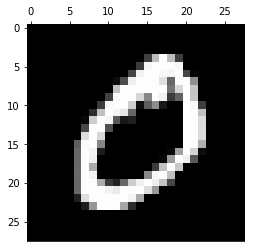

In [2]:
import matplotlib.pyplot as plt  
%matplotlib inline

#read images and show the second mage in training data set
(X, y), (Xtest, ytest) = joy.load_mnist(flatten=False)
joy.show_mnist(X[1])

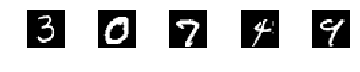

In [3]:
# show only 51~55th images
joy.show_mnist_grid(X[50:55])

Labels:[5 0 4 ... 5 6 8], y shape:(60000,), y type:<class 'numpy.ndarray'>


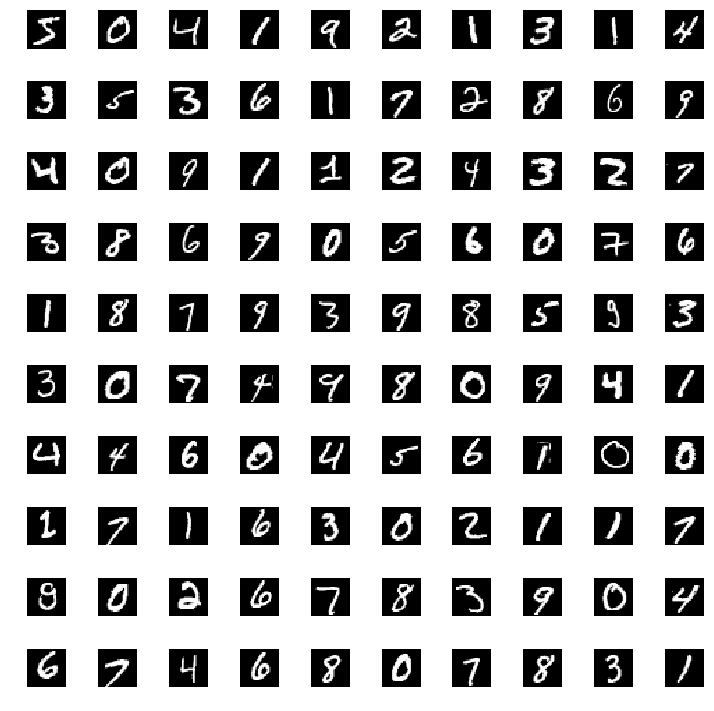

In [4]:
# show the first 100 images by default
print('Labels:{}, y shape:{}, y type:{}'.format(y, y.shape, type(y)))
joy.show_mnist_grid(X)

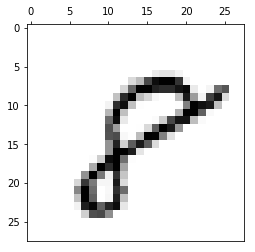

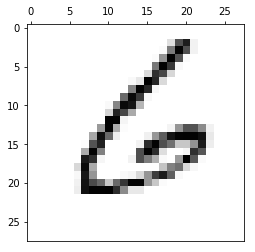

In [6]:
# show the last two images 
joy.show_mnist(X[-1], inverted = True)   
joy.show_mnist(X[-2], inverted = True)   

## save_mnist_csv()

You may save some data into a csv format file.

Labels: [5 0 4 ... 5 6 8]
Writing images(data\train100.csv)....

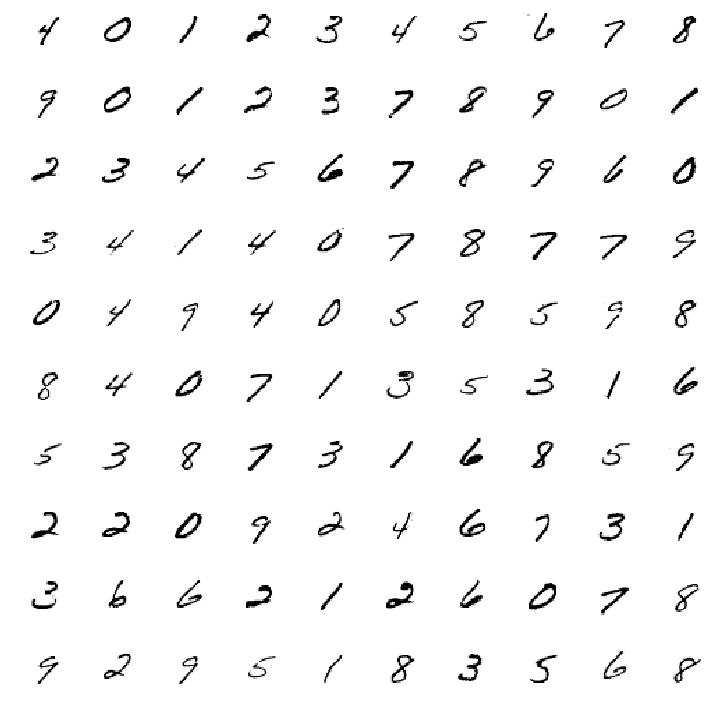

In [11]:
# read images from MNIST dataset, set flatten = False for display
(X, y), (Xtest, ytest) = joy.load_mnist(normalize = False, flatten = False) 

#show the last 100 images and save them into a csv formatted file 
print('Labels:', y)
joy.show_mnist_grid(X[-100:], inverted = True, ncols=10)
joy.save_mnist_csv(X[-100:], y[-100:], 'train100.csv')

## read_mnist_csv()

Read and display a csv file format. It assumes that the file exists under 'data' folder.

Reading images(data\train100.csv)...100
csv normalized X.shape=(100, 28, 28), y.shape=(100,)
X.shape=(100, 28, 28), y.shape=(100,)


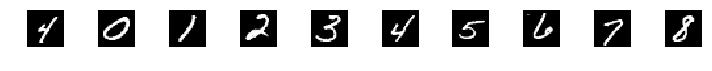

In [12]:
X, y = joy.read_mnist_csv('train100.csv')
print('X.shape={}, y.shape={}'.format(X.shape, y.shape))
joy.show_mnist_grid(X[:10])

## Display images one by one

Label: 5


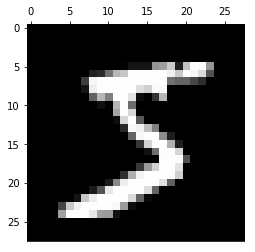

Label: 0


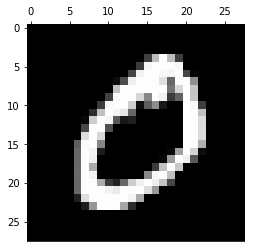

Label: 4


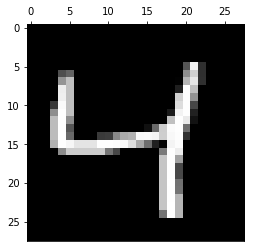

In [5]:
n_images = 3
(X, y), (Xt, yt) = joy.load_mnist(flatten = False)
for i, yi in enumerate(y[:3]):
    print('Label:', yi)
    joy.show_mnist(X[i])

## Rotate images and append them to process

### append_mnist_rotation()
    - read mnist dataset.
    - select the first five images and display them.  
    - display images and their labels. 

[5 0 4 1 9 1 5 0]


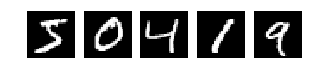

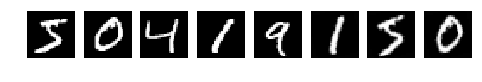

In [6]:
(X, y), (Xtest, ytest) = joy.load_mnist()    # reading mnist dataset
# select the first 5 images and show them 
Xo = X[:5].reshape(-1, 28, 28)
yo = y[:5]
joy.show_mnist_grid(Xo.reshape(-1, 28, 28))

Xr, yr = joy.append_mnist_rotation(Xo, yo, 3, 10)
joy.show_mnist_grid(Xr.reshape(-1, 28, 28))
print(yr)

## MNIST Dataset Processing Using Pretrained Weights

### FeedForward 3-Layer Neural Network 

<img src="images/MnistSGDOutline.png" width="600">
<center>Figure 4: MNIST Neural Network Feedforward</center>

In [11]:
g = lambda x : 1 / (1 + np.exp(-x))
##mnist feedforwad testing
(X, y) = joy.load_mnist_num(7)
joy.show_mnist(X.reshape(28,28))

W1 = joy.load_mnist_weight('data/w_xh.weights')
Z1 = np.dot(W1, X)
A1 = g(Z1)

W2 = joy.load_mnist_weight('data/w_hy.weights')
Z2 = np.dot(W2, A1)
yhat = g(Z2)

print('image:', y)
print('predict:', np.round_(yhat, 3))

NameError: name 'joy' is not defined

### Histogram of MNIST dataset

In [ ]:
(X, y), (Xtest, ytest) = joy.load_mnist()

In [ ]:
%%time



In [ ]:
%%time


In [ ]:
%%time



# Three layer neural network - Stochastic

Logistic Regression

<img src="images/multi-layerNN-4.PNG" width="600">
<center>Figure 5: MNIST Neural Network with Backpropagation </center>

In [ ]:
import joy
(X, y), (Xtest, ytest) = joy.load_mnist()
nn = joy.LogisticNeuron_stochastic(784, 100, 10, eta = 0.2, epochs = 3)  
nn.fit(X, y)       
self_accuracy = nn.evaluate(X, y)
test_accuracy = nn.evaluate(Xtest, ytest)
print('self_accuracy=', self_accuracy)  # 96.35
print('test_accuracy=', test_accuracy)  # 95.15

# Three layer neural network

<img src="images/2-3-2NN-ExampleBackProp.PNG" width="600">
<center>Figure 6: Three Layer Neural Network with Backpropagation </center>

Final prediction of all
[0 0] [0.077]
[0 1] [0.935]
[1 0] [0.94]
[1 1] [0.043]


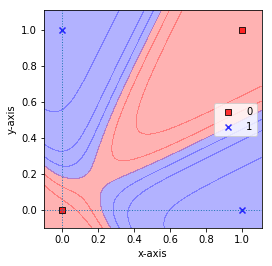

In [2]:
nn = joy.NeuralNetwork(net_arch=[2, 4, 1], eta=1.0, epochs=1000)
X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])   # input dataset - col vector     
Y = np.array([0, 1, 1, 0])                     # class labels  - for rcolvector  

nn.fit(X, Y)                                         # train the net

print("Final prediction of all")
A2 = nn.predict(X.T)
for x, yhat in zip(X.T, A2.T):
    print(x, np.round(yhat, 3))

joy.plot_decision_regions(X.T, Y, nn)   
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='best')
plt.show()

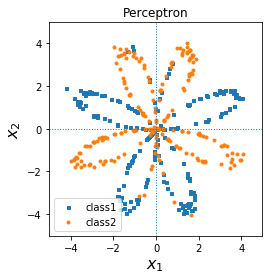

In [3]:
import joy

X, Y = joy.planar_data()            # X, Y = joy.noisy_moons()
joy.plot_xyw(X.T, Y.squeeze())
n_h = 4                            # 은닉층 노드의 수
nn = joy.LogisticNeuron(n_h)             # 클래스 객체 nn을 생성함.
nn.fit(X, Y)                         # 입력 자료 X와 클래스 레이블 Y보내어 가중치를 구함.

# References 

- MNIST training with Multi Layer Perceptron by [corochannNote](http://corochann.com/mnist-training-with-multi-layer-perceptron-1149.html)